Alisha Chulani - completed fine tuning steps for Parts 1 and 2

Katie Baakonen - completed set up for Part 2

Together - everything else

Both spent ~8 hours on assignment

Used ChatGPT to generate initial code and had to finetune to address bugs + data issues.

### Part 1: Character-level Transformer Model

In [173]:
import random
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
# from google.colab import drive
from transformers import BertModel, BertTokenizer
import torch
import torchvision
# !pip install datasets
# drive.mount('/content/drive')

All of the code for processing the text was copied over from Alisha's assignment from last week.

In [174]:
with open('english_small.txt', 'r') as file:
    #data = file.readlines()  # Read all lines into a list
    # If you want to read the entire content as a single string
    data = file.read()

import string

# Convert to lowercase
data = data.lower()

# Remove punctuation except periods
data_english = ''.join(c for c in data if (c.isalpha() and c in string.ascii_lowercase) or c.isspace() or c == '.')

In [175]:
# Specify the path to your text file
file_path = 'spanish_small.txt'

with open(file_path, 'r', encoding='latin-1') as file:
    data = file.read()  # Read entire content



# Convert to lowercase
data = data.lower()

# Remove non-English alphabet characters, keep whitespace and periods
data_spanish = ''.join(c for c in data if (c.isalpha() and (c in string.ascii_lowercase or c in 'áéíóúüñ')) or c.isspace() or c == '.')


In [176]:
import random
import numpy as np

# Parameters
N = 32  # Batch size
L = 75  # Length of each chunk of characters

# Find unique characters in English and Spanish texts
unique_chars = set(data_english + data_spanish)

# Create a custom character-to-integer mapping for the unique characters
char_to_int = {char: idx for idx, char in enumerate(unique_chars)}

# Print the unique character-to-integer mapping
print("Character-to-Integer Mapping:")
for char, idx in char_to_int.items():
    print(f"'{char}': {idx}")

def slice_and_label(text, label, L):
    """
    Slices the input text into chunks of length L, converts characters to integers,
    and labels them.

    Args:
    - text: string, input long text.
    - label: integer, 0 for English, 1 for Spanish.
    - L: int, length of each chunk.

    Returns:
    - A list of (chunk, label) tuples.
    """
    data = []
    # Slice the text into chunks of length L
    for i in range(0, len(text), L):
        chunk = text[i:i+L]
        # If the chunk is shorter than L, pad with spaces
        chunk = chunk + ' ' * (L - len(chunk))
        # Convert characters to integer values based on custom mapping
        chunk_indices = [char_to_int.get(c, 0) for c in chunk]  # 0 for unknown characters
        # Add (chunk, label) to the data list
        data.append((chunk_indices, label))
    return data

Character-to-Integer Mapping:
'q': 0
'j': 1
'x': 2
'
': 3
'.': 4
'm': 5
'g': 6
'e': 7
'c': 8
'd': 9
'y': 10
'p': 11
't': 12
'b': 13
'á': 14
'z': 15
'f': 16
'v': 17
'o': 18
'r': 19
'i': 20
'l': 21
'w': 22
'u': 23
'k': 24
'a': 25
'í': 26
'h': 27
'ñ': 28
'n': 29
' ': 30
'ú': 31
'é': 32
'ó': 33
's': 34


In [177]:
# Preprocess English and Spanish strings
english = slice_and_label(data_english, 0, L)
spanish = slice_and_label(data_spanish, 1, L)

In [178]:
print(english[0])
print(spanish[5])

([30, 3, 30, 30, 17, 25, 21, 24, 10, 19, 20, 25, 30, 8, 27, 19, 18, 29, 20, 8, 21, 7, 34, 30, 20, 20, 20, 30, 30, 3, 30, 3, 30, 34, 7, 29, 1, 30, 29, 18, 30, 17, 25, 21, 24, 10, 19, 20, 25, 30, 30, 30, 23, 29, 24, 30, 8, 27, 19, 18, 29, 20, 8, 21, 7, 34, 30, 30, 1, 25, 11, 25, 29, 7, 34], 0)
([34, 11, 7, 19, 25, 29, 12, 18, 30, 16, 7, 19, 7, 29, 8, 30, 34, 15, 20, 21, 14, 6, 10, 20, 3, 7, 21, 30, 8, 23, 25, 21, 30, 27, 7, 34, 34, 30, 25, 9, 25, 11, 12, 33, 30, 11, 25, 19, 25, 30, 21, 18, 34, 30, 7, 29, 3, 1, 18, 19, 6, 7, 30, 27, 7, 34, 34, 30, 12, 25, 5, 13, 20, 32, 29], 1)


In [179]:
# Combine and shuffle the data
combined_data = english + spanish
random.shuffle(combined_data)

# Split the data into inputs (X) and labels (y)
X = np.array([x[0] for x in combined_data])
y = np.array([x[1] for x in combined_data])

In [180]:
# Create a PyTorch Dataset
class LanguageDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)  # Convert to torch tensors
        self.y = torch.tensor(y, dtype=torch.long)  # Binary classification (float needed for loss function)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [181]:
# Create dataset
dataset = LanguageDataset(X, y)

# Split the dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader for training and validation datasets
train_dataloader = DataLoader(train_dataset, batch_size=N, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=N, shuffle=False)

Here, we define the transformer model.

In [182]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, seq_length, num_classes=2):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, seq_length, embed_dim))
        self.transformer_encoder = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads
        )
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x) + self.positional_encoding[:, :x.size(1), :]
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Mean pooling
        return self.fc(x)


Set the hyperparameters.

In [183]:
# Hyperparameters
vocab_size = len(unique_chars)  # Adjust based on the vocabulary size
embed_dim = 64
num_heads = 4
seq_length = L  # Adjust based on sequence length
learning_rate = 0.001
num_epochs = 5

# Initialize model, loss function, and optimizer
model = TransformerClassifier(vocab_size, embed_dim, num_heads, seq_length)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Define the training loop and train the model

In [184]:
def train(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):

    train_losses = []
    val_losses = []
    accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss/len(train_loader))

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                predictions = outputs.argmax(dim=1)
                correct += (predictions == labels).sum().item()

        val_losses.append(val_loss/len(val_loader))
        accuracies.append(correct/len(val_loader.dataset))

        print(f"Epoch {epoch+1}, Train Loss: {total_loss/len(train_loader)}, "
              f"Val Loss: {val_loss/len(val_loader)}, "
              f"Validation Accuracy: {correct/len(val_loader.dataset):.2f}")

    return train_losses, val_loss, accuracies

In [185]:
train_loss, val_loss, accuracies = train(model, train_dataloader, val_dataloader, num_epochs, learning_rate)

Epoch 1, Train Loss: 0.6204068376904442, Val Loss: 0.553646519780159, Validation Accuracy: 0.58
Epoch 2, Train Loss: 0.43942845861117047, Val Loss: 0.36607244114081067, Validation Accuracy: 0.83
Epoch 3, Train Loss: 0.3351541303452991, Val Loss: 0.2815462127327919, Validation Accuracy: 0.93
Epoch 4, Train Loss: 0.2651553551355998, Val Loss: 0.24270775417486826, Validation Accuracy: 0.92
Epoch 5, Train Loss: 0.23893152461165473, Val Loss: 0.2058019464214643, Validation Accuracy: 0.95



Define the plotting function and plot.

In [186]:
def display_losses_and_accuracy(train_loss, val_loss, accuracy_list):
    '''
    Plots training loss vs iteration and shows model parameters & test accuracy.

    Inputs:
        losses - history of training loss at each epoch
        w - model parameters
        X_test - test inputs
        y_test - test target values
    '''
    plt.figure(1)
    plt.plot(train_loss, 'b', label='Training Loss')
    plt.plot(val_loss, 'g', label='Validation Loss')
    plt.title('Loss vs Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

    plt.figure(2)
    plt.plot(accuracy_list, 'r')
    plt.title('Accuracy vs Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

    np.set_printoptions(precision=3)
    print("Percent Accuracy: ", accuracy_list[-1])

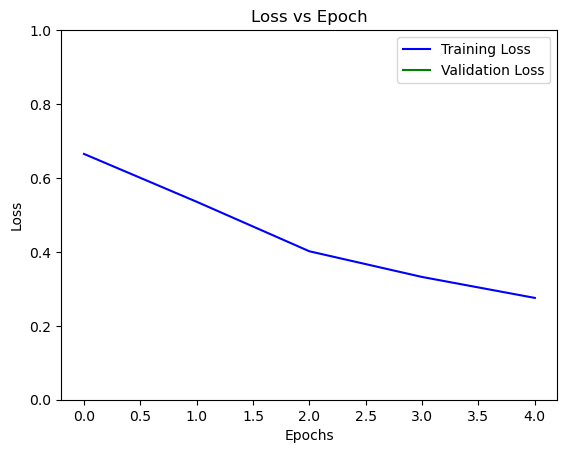

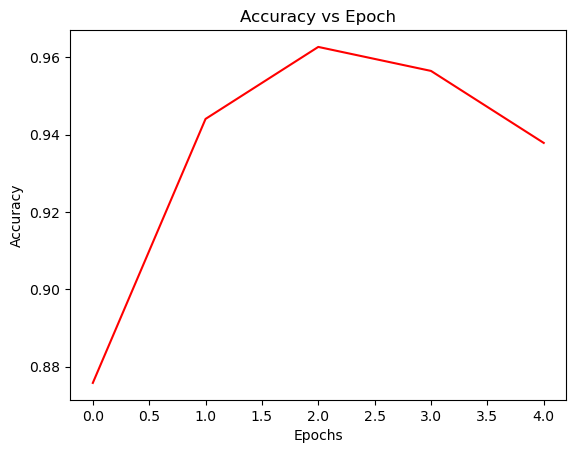

Percent Accuracy:  0.937888198757764


In [124]:
display_losses_and_accuracy(train_loss, val_loss, accuracies)



In the above example, we can see pretty good performance because the validation and training losses keep dropping across epochs, and training accuracy improves to 93%.

The following codecells adjust hyperparameters to test the performance of slightly differing models.

Model 2 first tries adjusting the embedding dimension to 128. We see that there is a signifcant drop in performance - the losses stagnate at around 0.7 as does the accuracy at 46%.


Epoch 1, Train Loss: 0.6550524745668683, Val Loss: 0.6769137978553772, Validation Accuracy: 0.58
Epoch 2, Train Loss: 0.673380366393498, Val Loss: 0.6769137978553772, Validation Accuracy: 0.58
Epoch 3, Train Loss: 0.6561294794082642, Val Loss: 0.6769137978553772, Validation Accuracy: 0.58
Epoch 4, Train Loss: 0.6557015152204604, Val Loss: 0.6769137978553772, Validation Accuracy: 0.58
Epoch 5, Train Loss: 0.6650794120061965, Val Loss: 0.6769137978553772, Validation Accuracy: 0.58


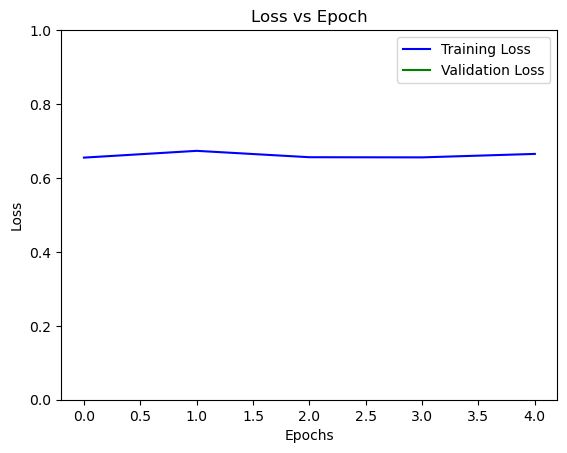

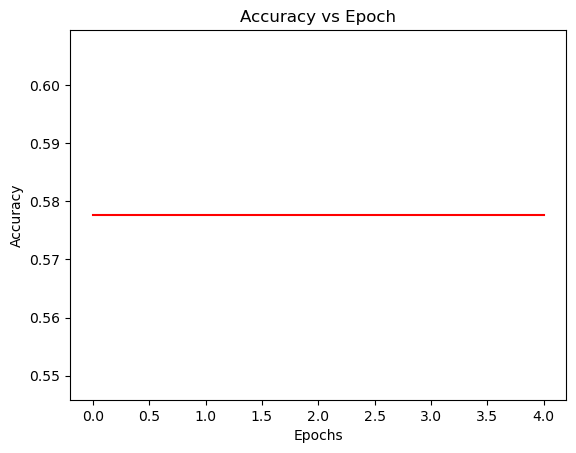

Percent Accuracy:  0.577639751552795


In [187]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, seq_length, num_classes=2):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, seq_length, embed_dim))
        self.transformer_encoder = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads
        )
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x) + self.positional_encoding[:, :x.size(1), :]
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Mean pooling
        return self.fc(x)


# Hyperparameters
vocab_size = len(unique_chars)  # Adjust based on the vocabulary size
embed_dim = 128
num_heads = 4
seq_length = L  # Adjust based on sequence length
learning_rate = 0.001
num_epochs = 5

# Initialize model, loss function, and optimizer
model2 = TransformerClassifier(vocab_size, embed_dim, num_heads, seq_length)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loss, val_loss, accuracies = train(model2, train_dataloader, val_dataloader, num_epochs, learning_rate)
display_losses_and_accuracy(train_loss, val_loss, accuracies)

Model 3 tries adjusting the embedding dimension to 32. We see that there is a signifcant drop in performance hera as well - the losses stagnate at around 0.68 as does the accuracy at 60%. While model 3 is better than model 2, the original model still performs the best.

Epoch 1, Train Loss: 0.7688011725743612, Val Loss: 0.7908616662025452, Validation Accuracy: 0.29
Epoch 2, Train Loss: 0.7671306303569249, Val Loss: 0.7908616662025452, Validation Accuracy: 0.29
Epoch 3, Train Loss: 0.7710400535946801, Val Loss: 0.7908616662025452, Validation Accuracy: 0.29
Epoch 4, Train Loss: 0.753944334529695, Val Loss: 0.7908616662025452, Validation Accuracy: 0.29
Epoch 5, Train Loss: 0.7692444352876573, Val Loss: 0.7908616662025452, Validation Accuracy: 0.29
Epoch 6, Train Loss: 0.7676239865166801, Val Loss: 0.7908616662025452, Validation Accuracy: 0.29
Epoch 7, Train Loss: 0.7687396293594724, Val Loss: 0.7908616662025452, Validation Accuracy: 0.29
Epoch 8, Train Loss: 0.7654283671152025, Val Loss: 0.7908616662025452, Validation Accuracy: 0.29
Epoch 9, Train Loss: 0.7611537887936547, Val Loss: 0.7908616662025452, Validation Accuracy: 0.29
Epoch 10, Train Loss: 0.7531622534706479, Val Loss: 0.7908616662025452, Validation Accuracy: 0.29


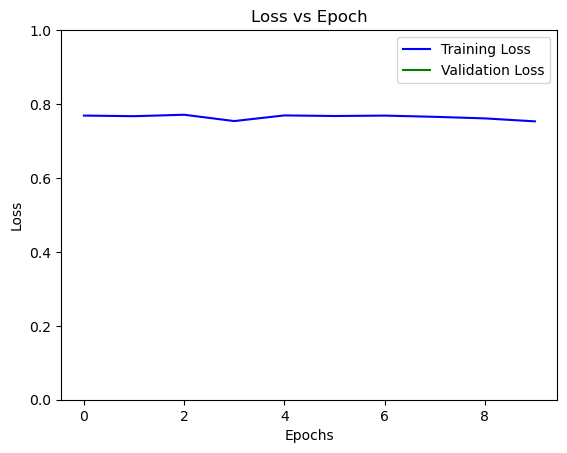

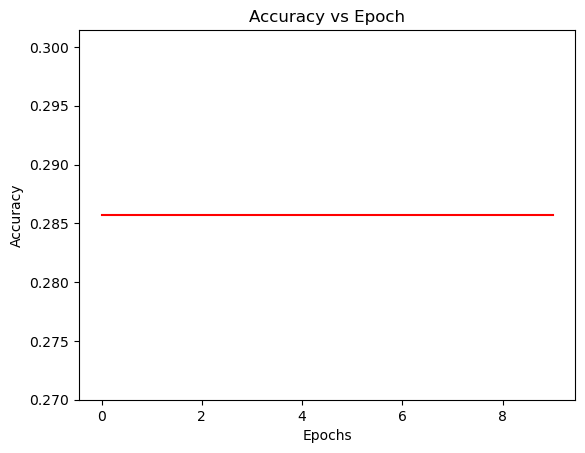

Percent Accuracy:  0.2857142857142857


In [126]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, seq_length, num_classes=2):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, seq_length, embed_dim))
        self.transformer_encoder = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads
        )
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x) + self.positional_encoding[:, :x.size(1), :]
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Mean pooling
        return self.fc(x)


# Hyperparameters
vocab_size = len(unique_chars)  # Adjust based on the vocabulary size
embed_dim = 32
num_heads = 4
seq_length = L  # Adjust based on sequence length
learning_rate = 0.001
num_epochs = 5

# Initialize model, loss function, and optimizer
model3 = TransformerClassifier(vocab_size, embed_dim, num_heads, seq_length)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loss, val_loss, accuracies = train(model3, train_dataloader, val_dataloader, 10, learning_rate)
display_losses_and_accuracy(train_loss, val_loss, accuracies)



For the next 2 models, we adjusted the number of heads. Model 4 adjusts it to 8, but we see that the performance worsens here with stagnating losses and accuracy.


Epoch 1, Train Loss: 0.65871300583794, Val Loss: 0.652333011229833, Validation Accuracy: 0.79
Epoch 2, Train Loss: 0.6630462322916303, Val Loss: 0.652333011229833, Validation Accuracy: 0.79
Epoch 3, Train Loss: 0.6625510993457976, Val Loss: 0.652333011229833, Validation Accuracy: 0.79
Epoch 4, Train Loss: 0.6622905191921052, Val Loss: 0.652333011229833, Validation Accuracy: 0.79
Epoch 5, Train Loss: 0.659016952628181, Val Loss: 0.652333011229833, Validation Accuracy: 0.79
Epoch 6, Train Loss: 0.6603731030509585, Val Loss: 0.652333011229833, Validation Accuracy: 0.79
Epoch 7, Train Loss: 0.6621563860348293, Val Loss: 0.652333011229833, Validation Accuracy: 0.79
Epoch 8, Train Loss: 0.6605080593199957, Val Loss: 0.652333011229833, Validation Accuracy: 0.79
Epoch 9, Train Loss: 0.6585126377287365, Val Loss: 0.652333011229833, Validation Accuracy: 0.79
Epoch 10, Train Loss: 0.6620422317868188, Val Loss: 0.652333011229833, Validation Accuracy: 0.79


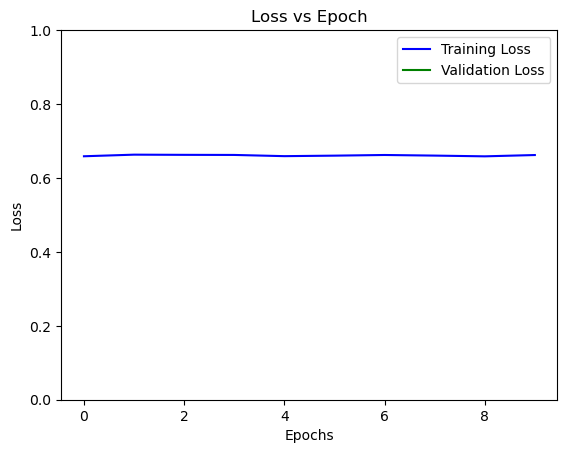

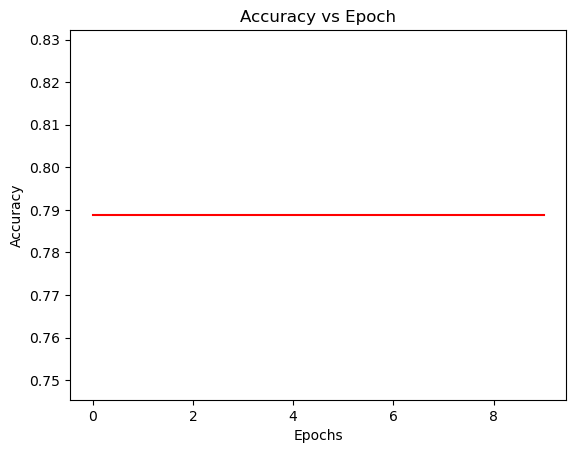

Percent Accuracy:  0.7888198757763976


In [127]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, seq_length, num_classes=2):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, seq_length, embed_dim))
        self.transformer_encoder = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads
        )
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x) + self.positional_encoding[:, :x.size(1), :]
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Mean pooling
        return self.fc(x)


# Hyperparameters
vocab_size = len(unique_chars)  # Adjust based on the vocabulary size
embed_dim = 64
num_heads = 8
seq_length = L  # Adjust based on sequence length
learning_rate = 0.001
num_epochs = 5

# Initialize model, loss function, and optimizer
model4 = TransformerClassifier(vocab_size, embed_dim, num_heads, seq_length)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loss, val_loss, accuracies = train(model4, train_dataloader, val_dataloader, 10, learning_rate)
display_losses_and_accuracy(train_loss, val_loss, accuracies)



Model 5 adjusts it to 2, but we see that the performance worsens here with stagnating losses and accuracy as well.


Epoch 1, Train Loss: 0.7333368034589858, Val Loss: 0.7551604807376862, Validation Accuracy: 0.29
Epoch 2, Train Loss: 0.7286603053410848, Val Loss: 0.7551604807376862, Validation Accuracy: 0.29
Epoch 3, Train Loss: 0.7257577180862427, Val Loss: 0.7551604807376862, Validation Accuracy: 0.29
Epoch 4, Train Loss: 0.7307295458657401, Val Loss: 0.7551604807376862, Validation Accuracy: 0.29
Epoch 5, Train Loss: 0.7304820361591521, Val Loss: 0.7551604807376862, Validation Accuracy: 0.29
Epoch 6, Train Loss: 0.7320250215984526, Val Loss: 0.7551604807376862, Validation Accuracy: 0.29
Epoch 7, Train Loss: 0.7266102603503636, Val Loss: 0.7551604807376862, Validation Accuracy: 0.29
Epoch 8, Train Loss: 0.7311842413175673, Val Loss: 0.7551604807376862, Validation Accuracy: 0.29
Epoch 9, Train Loss: 0.7316752473513285, Val Loss: 0.7551604807376862, Validation Accuracy: 0.29
Epoch 10, Train Loss: 0.7266305940491813, Val Loss: 0.7551604807376862, Validation Accuracy: 0.29


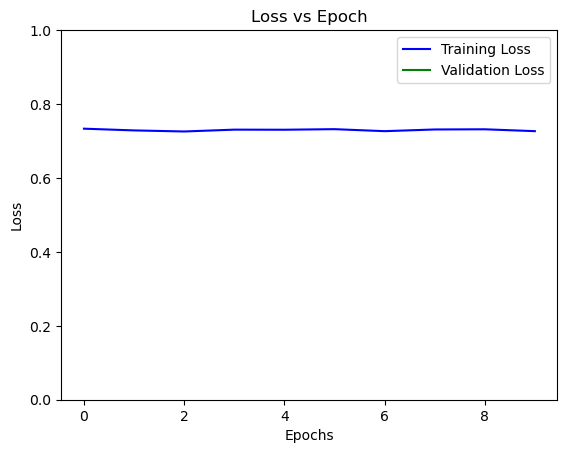

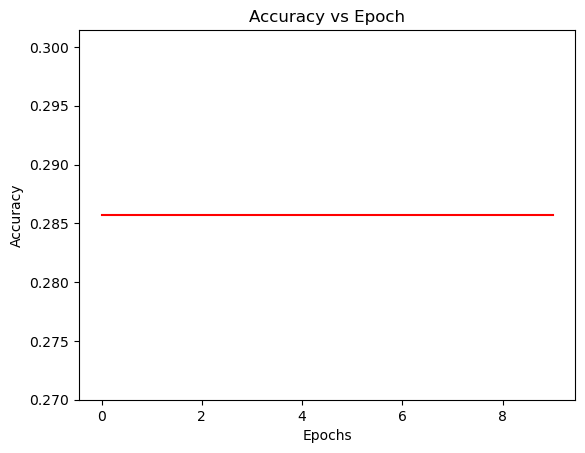

Percent Accuracy:  0.2857142857142857


In [128]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, seq_length, num_classes=2):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, seq_length, embed_dim))
        self.transformer_encoder = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads
        )
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x) + self.positional_encoding[:, :x.size(1), :]
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Mean pooling
        return self.fc(x)


# Hyperparameters
vocab_size = len(unique_chars)  # Adjust based on the vocabulary size
embed_dim = 64
num_heads = 2
seq_length = L  # Adjust based on sequence length
learning_rate = 0.001
num_epochs = 5

# Initialize model, loss function, and optimizer
model5 = TransformerClassifier(vocab_size, embed_dim, num_heads, seq_length)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loss, val_loss, accuracies = train(model5, train_dataloader, val_dataloader, 10, learning_rate)
display_losses_and_accuracy(train_loss, val_loss, accuracies)

Thus, the highest performing model was the original one - adjusting embedded layers and number of heads did not improve performance. Below, we define a testing function and test on sample sentences.

In [154]:
def test_model_on_sentence(sentence, model, char_to_int, L):
    """
    Test the trained model on a specific input sentence.

    Args:
    - sentence (str): The input sentence to classify.
    - model (nn.Module): The trained LSTM model.
    - char_to_int (dict): The character-to-integer mapping.
    - L (int): The length to pad/truncate the sentence to.

    Returns:
    - None: Prints out whether the sentence is classified as English or Spanish.
    """

    # Preprocess the sentence: convert characters to integer indices
    sentence = sentence[:L]  # Truncate if longer than L
    sentence = sentence + ' ' * (L - len(sentence))  # Pad with spaces if shorter than L
    sentence_indices = [char_to_int.get(c, 0) for c in sentence]  # Convert to integer mapping

    # Convert to tensor and add batch dimension
    input_tensor = torch.tensor([sentence_indices], dtype=torch.long)

    # Set model to evaluation mode
    model.eval()

    # Pass the input through the model
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted_label = torch.max(output, 1)  # Get the index of the max logit

    # Interpret the result
    if predicted_label.item() == 0:
        print(f"The sentence is classified as English: '{sentence.strip()}'")
    else:
        print(f"The sentence is classified as Spanish: '{sentence.strip()}'")


In [155]:
# Example usage:
test_model_on_sentence("This is a test sentence.", model, char_to_int, L)
test_model_on_sentence("Esta es una frase en inglés.", model, char_to_int, L)
test_model_on_sentence("I like pie.", model, char_to_int, L)
test_model_on_sentence("Esta es una frase.", model, char_to_int, L)
test_model_on_sentence("Soy de la ciudad y me gustan los plátanos y me gusta el color verde y tengo el pelo oscuro.", model, char_to_int, L)
test_model_on_sentence("Yo soy de la ciudad y me gustan los plátanos y me gusta el color verde y tengo el pelo oscuro.", model, char_to_int, L)

The sentence is classified as English: 'This is a test sentence.'
The sentence is classified as English: 'Esta es una frase en inglés.'
The sentence is classified as English: 'I like pie.'
The sentence is classified as English: 'Esta es una frase.'
The sentence is classified as Spanish: 'Soy de la ciudad y me gustan los plátanos y me gusta el color verde y tengo'
The sentence is classified as Spanish: 'Yo soy de la ciudad y me gustan los plátanos y me gusta el color verde y te'




Looking at the results above, it looks like our model performs pretty well with the above inputs, with only 2 of them being incorrect. It seems that our model performs better on longer sentences. Our intuition is that the model does not perform as well with sentences that are smaller than the input batches we used (75 characters) for the training, which is why the 4th example fails, since it is a short Spanish sentence.


### Part 2: Finetuning a Pretrained Language Model

Find a pretrained BERT language model and
extract features from the output of the last Transformer layer.

In [188]:
# Load pretrained BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)


def extract_sentence_features(sentence, model):
    # Tokenize input
    inputs = tokenizer(sentence, return_tensors="pt")

    # Extract features from the last transformer layer
    with torch.no_grad():
        outputs = model(**inputs)

    # The last hidden states are the output of the last Transformer layer
    # `outputs.last_hidden_state` has shape (batch_size, sequence_length, hidden_size)
    last_hidden_states = outputs.last_hidden_state

    # For example, extracting features for each token
    print("Shape of last_hidden_states:", last_hidden_states.shape)
    print("Features for each token in the sentence:", last_hidden_states)


Display features:

In [189]:
extract_sentence_features('anything whatever you want', bert_model)

Shape of last_hidden_states: torch.Size([1, 6, 768])
Features for each token in the sentence: tensor([[[ 0.2612,  0.1177,  0.0588,  ..., -0.2571, -0.3038,  0.0414],
         [ 0.3374,  0.1897, -0.1236,  ...,  0.0223, -0.4033, -0.2017],
         [ 0.0817,  0.8534,  0.9179,  ..., -0.0672, -0.4596, -0.1705],
         [-0.7767, -0.4385,  0.5462,  ...,  0.5063, -0.9121, -0.9561],
         [ 0.0695,  0.2763,  0.3504,  ..., -0.5594, -0.8722, -0.2562],
         [ 0.7623, -0.1646, -0.0682,  ..., -0.0475, -0.6291, -0.2580]]])


The following pieces of code process the dataset in a similar manner to the Part 1, but instead do not perform an integer encoding and leave it as strings.

In [190]:
def slice_and_label_no_num(text, label, L):
    """
    Slices the input text into chunks of length L, converts characters to integers,
    and labels them.

    Args:
    - text: string, input long text.
    - label: integer, 0 for English, 1 for Spanish.
    - L: int, length of each chunk.

    Returns:
    - A list of (chunk, label) tuples.
    """
    data = []
    # Slice the text into chunks of length L
    for i in range(0, len(text), L):
        chunk = text[i:i+L]
        # If the chunk is shorter than L, pad with spaces
        chunk = chunk + ' ' * (L - len(chunk))
        # Add (chunk, label) to the data list
        data.append((chunk, label))
    return data

In [191]:
# Preprocess English and Spanish

english = slice_and_label_no_num(data_english, 0, L)
spanish = slice_and_label_no_num(data_spanish, 1, L)

In [192]:
from datasets import Dataset

# Combine and shuffle the data
combined_data = english + spanish
random.shuffle(combined_data)

X = [x[0] for x in combined_data]
y = torch.tensor([x[1] for x in combined_data])

def my_gen():
    for i in range(len(X)):
        yield {'text': X[i], 'label':y[i]}


In [193]:
dataset = Dataset.from_generator(my_gen)

In [194]:
dataset = dataset.class_encode_column('label')

In [195]:
from transformers import BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")

inputs = tokenizer(X, padding=True, truncation=True, return_tensors='pt')


model = BertForSequenceClassification.from_pretrained("google-bert/bert-base-uncased", num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [196]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)


In [197]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

In [198]:
tokenized_datasets = tokenized_datasets.train_test_split(test_size=0.2)

In [199]:
# !pip install evaluate

In [200]:
import evaluate

metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)


Set up the linear probe model here and train.

In [202]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(eval_strategy="steps",
                                  num_train_epochs=1,
                                  per_device_train_batch_size=4,
                                  logging_steps=50,
                                  per_device_eval_batch_size=4,
                                  eval_steps=50,
                                  output_dir='/Users/katie/Library/CloudStorage/OneDrive-HarveyMuddCollege/2024 Fall/E208/hw8'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
)

In [203]:
import os
os.environ["WANDB_MODE"] = "disabled"

In [204]:
train_result = trainer.train()

  0%|          | 0/161 [00:00<?, ?it/s]

{'loss': 0.0889, 'grad_norm': 0.01796558126807213, 'learning_rate': 3.4472049689440996e-05, 'epoch': 0.31}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 0.0007501810905523598, 'eval_accuracy': 1.0, 'eval_runtime': 34.3143, 'eval_samples_per_second': 4.692, 'eval_steps_per_second': 1.195, 'epoch': 0.31}
{'loss': 0.0017, 'grad_norm': 0.018049847334623337, 'learning_rate': 1.894409937888199e-05, 'epoch': 0.62}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 0.0003260535595472902, 'eval_accuracy': 1.0, 'eval_runtime': 30.9559, 'eval_samples_per_second': 5.201, 'eval_steps_per_second': 1.324, 'epoch': 0.62}
{'loss': 0.0004, 'grad_norm': 0.008572904393076897, 'learning_rate': 3.4161490683229816e-06, 'epoch': 0.93}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 0.00024153402773663402, 'eval_accuracy': 1.0, 'eval_runtime': 27.8409, 'eval_samples_per_second': 5.783, 'eval_steps_per_second': 1.473, 'epoch': 0.93}
{'train_runtime': 542.3291, 'train_samples_per_second': 1.184, 'train_steps_per_second': 0.297, 'train_loss': 0.028304172457074343, 'epoch': 1.0}




Access training logs for plotting.


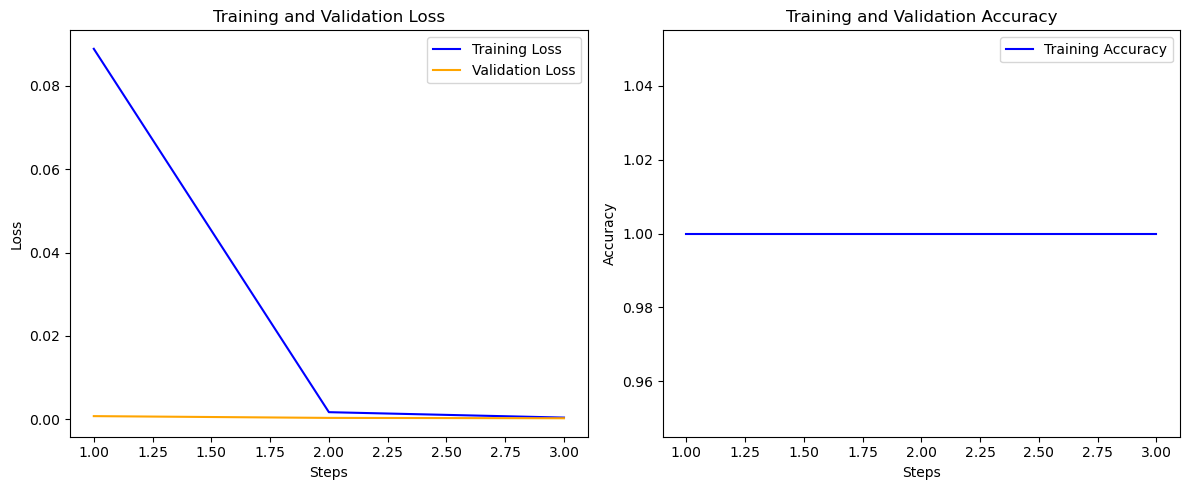

In [205]:
# Access training logs
train_logs = trainer.state.log_history

train_loss = []
eval_loss = []
train_accuracy = []
eval_accuracy = []

for log in train_logs:
    if 'loss' in log:
        train_loss.append(log['loss'])
    if 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])
    if 'eval_accuracy' in log:
        eval_accuracy.append(log['eval_accuracy'])
    if 'accuracy' in log:
        train_accuracy.append(log['accuracy'])

# Create a step range for plotting
steps = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(steps, train_loss, label='Training Loss', color='blue')
plt.plot(steps, eval_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(steps, eval_accuracy, label='Training Accuracy', color='blue')
plt.title('Training and Validation Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



We can see a great jump in performance compared to the training model in Part 1, with losses dropping significantly and accuracy reaching 99%.

Unfreeze the model and train and plot again.


In [206]:
# unfreeze model

for param in model.parameters():
    param.requires_grad = True

# Optionally adjust training arguments for fine-tuning
fine_tuning_training_args = TrainingArguments(
    output_dir='/Users/katie/Library/CloudStorage/OneDrive-HarveyMuddCollege/2024 Fall/E208/hw8',  # Adjust as needed
    num_train_epochs=1,  # Number of epochs for fine-tuning
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    evaluation_strategy="steps",
    logging_steps=50,
    eval_steps=50,
    logging_dir='./logs_fine_tuning'  # Separate logging directory
)

# Create a new Trainer instance for fine-tuning
fine_tuning_trainer = Trainer(
    model=model,
    args=fine_tuning_training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
)



/opt/anaconda3/envs/E208_F24/lib/python3.11/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [207]:
os.environ["WANDB_MODE"] = "disabled"

In [208]:
fine_tuning_trainer.train()

  0%|          | 0/161 [00:00<?, ?it/s]

{'loss': 0.0001, 'grad_norm': 0.00016768646310083568, 'learning_rate': 3.4472049689440996e-05, 'epoch': 0.31}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 4.2648689486668445e-06, 'eval_accuracy': 1.0, 'eval_runtime': 35.0151, 'eval_samples_per_second': 4.598, 'eval_steps_per_second': 1.171, 'epoch': 0.31}
{'loss': 0.0, 'grad_norm': 0.00015435507521033287, 'learning_rate': 1.894409937888199e-05, 'epoch': 0.62}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 2.7729074645321816e-06, 'eval_accuracy': 1.0, 'eval_runtime': 27.0916, 'eval_samples_per_second': 5.943, 'eval_steps_per_second': 1.513, 'epoch': 0.62}
{'loss': 0.0, 'grad_norm': 9.212099394062534e-05, 'learning_rate': 3.4161490683229816e-06, 'epoch': 0.93}


  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 2.4108383058774052e-06, 'eval_accuracy': 1.0, 'eval_runtime': 27.3481, 'eval_samples_per_second': 5.887, 'eval_steps_per_second': 1.499, 'epoch': 0.93}
{'train_runtime': 533.7468, 'train_samples_per_second': 1.203, 'train_steps_per_second': 0.302, 'train_loss': 2.8237779187298848e-05, 'epoch': 1.0}


TrainOutput(global_step=161, training_loss=2.8237779187298848e-05, metrics={'train_runtime': 533.7468, 'train_samples_per_second': 1.203, 'train_steps_per_second': 0.302, 'total_flos': 168917297541120.0, 'train_loss': 2.8237779187298848e-05, 'epoch': 1.0})

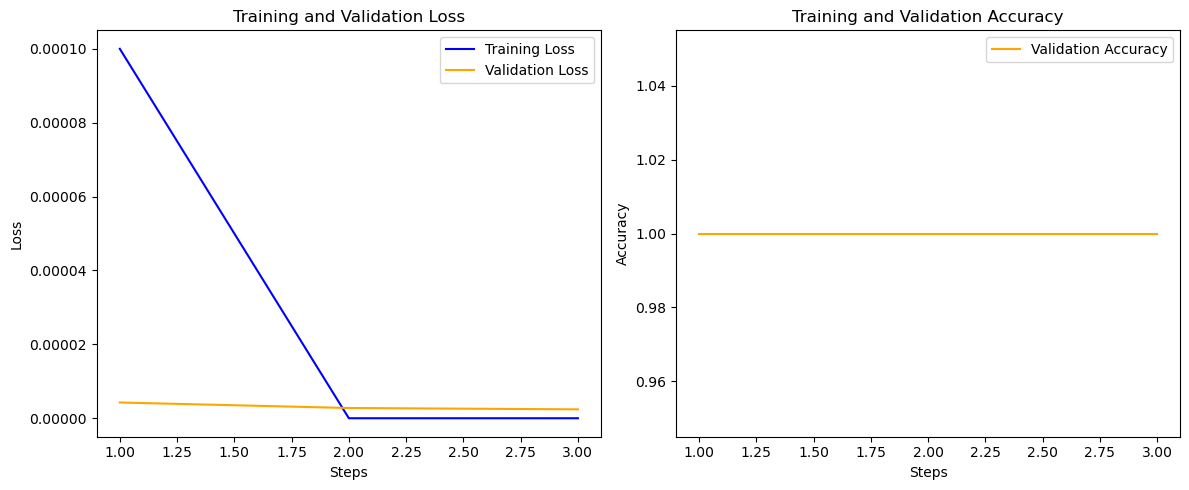

In [209]:
# Access training logs
train_logs = fine_tuning_trainer.state.log_history

# Prepare data for plotting
train_loss = []
eval_loss = []
train_accuracy = []
eval_accuracy = []

for log in train_logs:
    if 'loss' in log:
        train_loss.append(log['loss'])
    if 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])
    if 'eval_accuracy' in log:
        eval_accuracy.append(log['eval_accuracy'])
    if 'accuracy' in log:
        train_accuracy.append(log['accuracy'])


# Create a step range for plotting
steps = range(1, len(train_loss) + 1)

# Plotting loss and accuracy
plt.figure(figsize=(12, 5))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(steps, train_loss, label='Training Loss', color='blue')
plt.plot(steps, eval_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(steps, eval_accuracy, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

The finetuned model had the same accuracy as the linear probe, probably because we had such a small dataset. There were a lot of issues with getting the model from hugging face to run. It took longer than I would have expected for such a small dataset. 

### Part 3: Prompting a Foundation Model

The sun sets beautifully over the horizon.
She enjoys reading books in her free time.
El sol se pone hermosamente sobre el horizonte.
The dog barked loudly at the passing car.
A ella le gusta leer libros en su tiempo libre.
They plan to travel to Europe next summer.
El perro ladró fuertemente al coche que pasaba.
He makes the best chocolate chip cookies.
Ellos planean viajar a Europa el próximo verano.
Él hace las mejores galletas de chispas de chocolate.

Were the sentences we used.

We noticed first of all that we had to be very specific when prompting Chat on what the output we wanted was. We had to specify very clearly that we wanted to classify each sentence as either English or Spanish for all 10 sentences, otherwise when we would run it it would only classify the first, or only extract the English sentences. For example, "english or spanish?" followed by the list produced incomplete answers. Additionally, formatting was super important because if the sentences were not formatted in a clear and consistent way, the prompt would not generate an accuracte answer. For example, when the sentences were together in a single paragraph, the model could not provide distinguished answers by the sentence. We settled on providing the sentences as a bulleted list.

Our final prompt that seemed to provide the best answers was:

In [167]:
prompt = f"""
Decide if the following sentences are English or Spanish:

` The sun sets beautifully over the horizon.
` She enjoys reading books in her free time.
` El sol se pone hermosamente sobre el horizonte.
` The dog barked loudly at the passing car.
` A ella le gusta leer libros en su tiempo libre.
` They plan to travel to Europe next summer.
` El perro ladró fuertemente al coche que pasaba.
` He makes the best chocolate chip cookies.
` Ellos planean viajar a Europa el próximo verano.
` Él hace las mejores galletas de chispas de chocolate.

"""
response = get_completion(prompt)
print(response)

NameError: name 'get_completion' is not defined

We ran the above code cell in the course environment and got perfectly accurate answers this way outputted in a clear and easy to read format as we wanted. We also used this course environment to do a subset of the English and Spanish data, with losses nearing 0.13 and an accuracy of 98%.